# Dependencies

In [ ]:
! pip install --upgrade transformers --quiet

In [ ]:
! pip install torch --upgrade --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.0+cu121 requires torch==2.5.0, but you have torch 2.5.1 which is incompatible.
torchvision 0.20.0+cu121 requires torch==2.5.0, but you have torch 2.5.1 which is incompatible.


In [ ]:
! pip install bitsandbytes accelerate --upgrade --quiet

# Run Inference with Molmo

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoProcessor, GenerationConfig, BitsAndBytesConfig
from PIL import Image
import requests

load_in_8bit = False
load_in_4bit = True
mixed_precision = "bf16"

device_map = "auto"
torch_dtype = torch.bfloat16

quantization_config = BitsAndBytesConfig(
        load_in_8bit=load_in_8bit, load_in_4bit=load_in_4bit
)

# load the processor
processor = AutoProcessor.from_pretrained(
    'allenai/Molmo-7B-O-0924',
    trust_remote_code=True,
    device_map=device_map,
    torch_dtype=torch.bfloat16,
)

# load the model
model = AutoModelForCausalLM.from_pretrained(
    'allenai/Molmo-7B-O-0924',
    trust_remote_code=True,
    quantization_config=quantization_config,
    device_map=device_map,
    torch_dtype=torch.bfloat16,
)


prompt = 'pallet jack' # @param {type:"string"}
image_url = 'https://remyx.ai/assets/spatialvlm/warehouse_rgb.jpg' # @param {type:"string"}

# process the image and text
img = Image.open(requests.get(image_url, stream=True).raw)
inputs = processor.process(
    images=[img],
    text="Point to the {} in the scene.".format(prompt),
)
inputs["images"] = inputs["images"].to(torch.bfloat16)

inputs = {k: v.to(model.device).unsqueeze(0) for k, v in inputs.items()}
with torch.no_grad():
        with torch.cuda.amp.autocast(dtype=torch.bfloat16):
                output = model.generate_from_batch(
                    inputs,
                    GenerationConfig(max_new_tokens=200, stop_strings="<|endoftext|>"),
                    tokenizer=processor.tokenizer
                )

                # only get generated tokens; decode them to text
                generated_tokens = output[0,inputs['input_ids'].size(1):]
                generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)

                # print the generated text
                print(generated_text)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

 <point x="37.1" y="45.7" alt="pallet jack in the scene.">pallet jack in the scene.</point>


# Parsing Points from Molmo's Response
## https://huggingface.co/allenai/Molmo-7B-O-0924/discussions/1

In [ ]:
import re
import numpy as np

def extract_points(molmo_output, image_w, image_h):
    all_points = []
    for match in re.finditer(r'x\d*="\s*([0-9]+(?:\.[0-9]+)?)"\s+y\d*="\s*([0-9]+(?:\.[0-9]+)?)"', molmo_output):
        try:
            point = [float(match.group(i)) for i in range(1, 3)]
        except ValueError:
            pass
        else:
            point = np.array(point)
            if np.max(point) > 100:
                # Treat as an invalid output
                continue
            point /= 100.0
            point = point * np.array([image_w, image_h])
            all_points.append(point)
    return all_points


w, h = img.size
points = extract_points(generated_text, w, h)

# Segmenting with SAM2

In [ ]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [ ]:
if True:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything-2.git'

    !mkdir -p images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything-2/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything-2/main/notebooks/images/groceries.jpg

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt

PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.0+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything-2.git to /tmp/pip-req-build-cuz_9a5d
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything-2.git /tmp/pip-req-build-cuz_9a5d
  Resolved https://github.com/facebookresearch/segment-anything-2.git to commit c2ec8e14a185632b0a5d8b161928ceb50197eddc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━

In [ ]:
import numpy as np

np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [ ]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

img = img.convert("RGB")
predictor.set_image(img)

# Visualizing our Segmented Region

/usr/local/lib/python3.10/dist-packages/sam2/sam2_image_predictor.py:314: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  point_coords = torch.as_tensor(


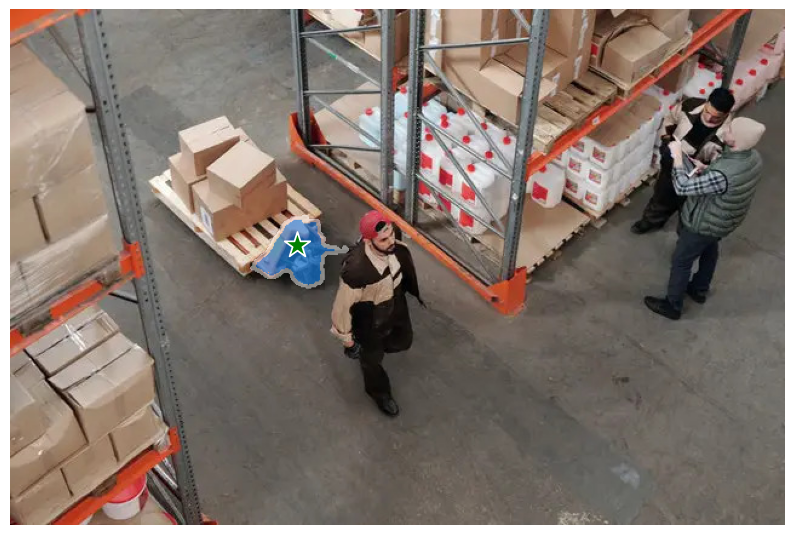

In [ ]:
import matplotlib.pyplot as plt


input_labels = np.ones(len(points))
masks, scores, _ = predictor.predict(
    point_coords=points,
    point_labels=input_labels,
    box=None,
    multimask_output=False,
)

show_masks(img, masks, scores, point_coords=np.array(points), input_labels=input_labels)